# Model Free prediction & Monte Carlo Control

Model Free -- Estimate the value function of an unknown MDP

MC methods have high variance (due to lots of random decisions within an episode) but are unbiased.

## Black Jack Playground

In [1]:
import numpy as np
import sys
# if "../" not in sys.path:
#   sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv

In [3]:
env = BlackjackEnv()

def print_observation(observation):
    score, dealer_score, usable_ace = observation
    print("Player score: {} (Usable Ace: {}), dealer_score: {}".format(score, usable_ace, dealer_score))

    
# Stick (action 0) if the score is >= 20, hit (action 1) otherwise
def strategy(observation):
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        print_observation(observation)
        action = strategy(observation)
        print("Taking Action: {}".format(['Stick','Hit'][action]))
        observation, reward, done, _ = env.step(action)
        if done:
            print_observation(observation)
            print("Game end. Reward: {}\n".format(float(reward)))
            break      

Player score: 17 (Usable Ace: False), dealer_score: 10
Taking Action: Hit
Player score: 24 (Usable Ace: False), dealer_score: 10
Game end. Reward: -1.0

Player score: 20 (Usable Ace: False), dealer_score: 2
Taking Action: Stick
Player score: 20 (Usable Ace: False), dealer_score: 2
Game end. Reward: 1.0

Player score: 17 (Usable Ace: False), dealer_score: 4
Taking Action: Hit
Player score: 20 (Usable Ace: False), dealer_score: 4
Taking Action: Stick
Player score: 20 (Usable Ace: False), dealer_score: 4
Game end. Reward: 1.0

Player score: 18 (Usable Ace: False), dealer_score: 10
Taking Action: Hit
Player score: 22 (Usable Ace: False), dealer_score: 10
Game end. Reward: -1.0

Player score: 12 (Usable Ace: False), dealer_score: 10
Taking Action: Hit
Player score: 22 (Usable Ace: False), dealer_score: 10
Game end. Reward: -1.0

Player score: 14 (Usable Ace: True), dealer_score: 6
Taking Action: Hit
Player score: 14 (Usable Ace: False), dealer_score: 6
Taking Action: Hit
Player score: 24 (U

## Now lets use Monte-Carlo to play BlackJack
Algorithm in summary:

-- Initialization (define a sample_policy genereation as described before as well )

-- Repeat for n episodes:

        -- Generate an episode using the initiate policy \pi 
           The episode finishes in two cases: Game finish or Time runs out....
        -- for each state s appearing in the episode (use set(s) here)
                -- Calculate the total discounted reward G(s) by sum up all rewards since the first occruance of 
                this state
                -- Calculate the average return for this state s: sum returns[s] / sum count[s]
End   

Noteworthy, there's no convergence limitation in simple Monte-Carlo method, just run the episodes hundreds of thousands times....

In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [26]:
# episode = env.reset()
# print(episode)
    # the result is a state: (20, 8, True)

In [27]:
# state = env.reset()
# print(state)
    # (13, 10, True)
    # Player score: 13, Dealer score: 10, Usable ace: True
    # ovservation = state
# action = sample_policy(state)
# print(action)
    # array([ 0.,  1.])
    # which is Hits


In [28]:
# observation, reward, done, _ = env.step(action)
# after env.step(action), we get ((20, 10, False), 0, False, {})
# observation is next state: (20, 10, False), reward is 0, done is False

In [14]:
env = BlackjackEnv()

def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value-state function
    V = defaultdict(float)
    for i_episode in range(1,num_episodes):
      
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
           
        # generate an episode
        episode = []
        state = env.reset()
        
        # run an episode by the default policy
        for t in range(100):
            action = policy(state)
            # take the action will then generate next state(observation), current reward, done
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        # convert episode into a dictionary so that we can use s as the key
        state_in_episode = set(tuple(x[0]) for x in episode)
        for state in state_in_episode:
            # find the first occurance of this state
            state_idx = next(i for i,x in enumerate(episode) if x[0] == state)
            G = sum(x[2] * (discount_factor**i) for i,x in enumerate(episode[state_idx:]))
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state]/returns_count[state]
            
    return V

In [15]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1


Episode 9000/10000.

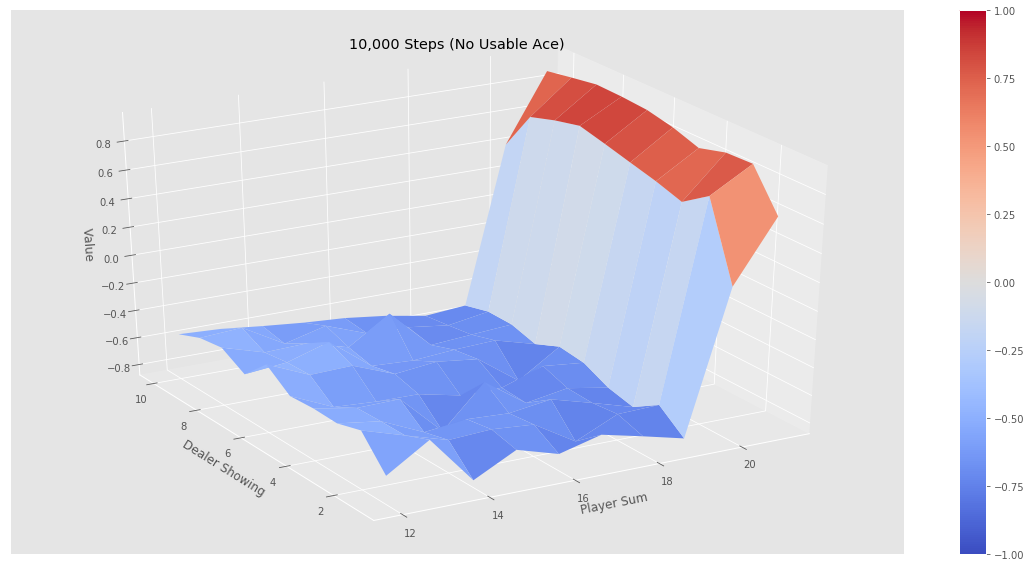

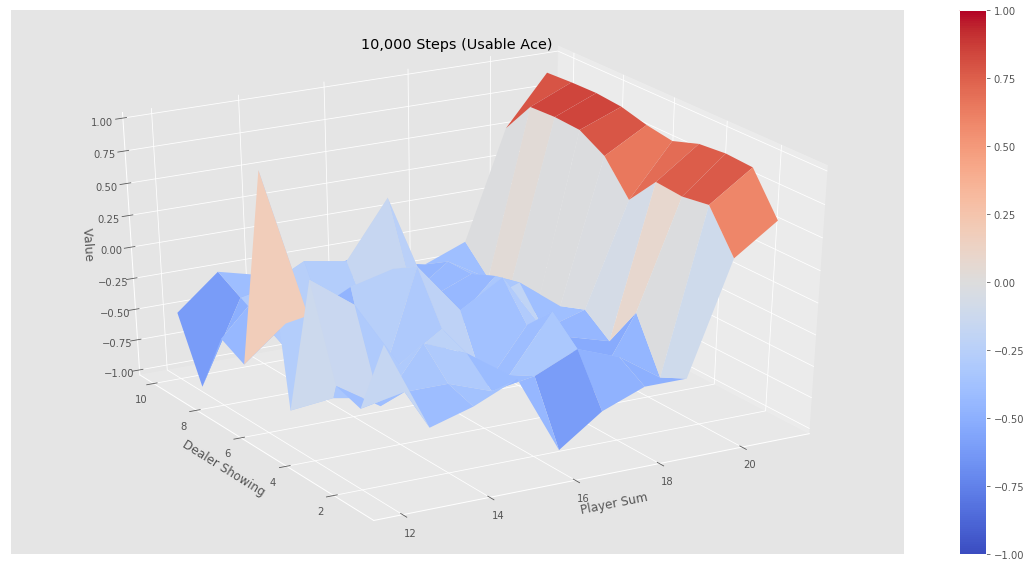

Episode 499000/500000.

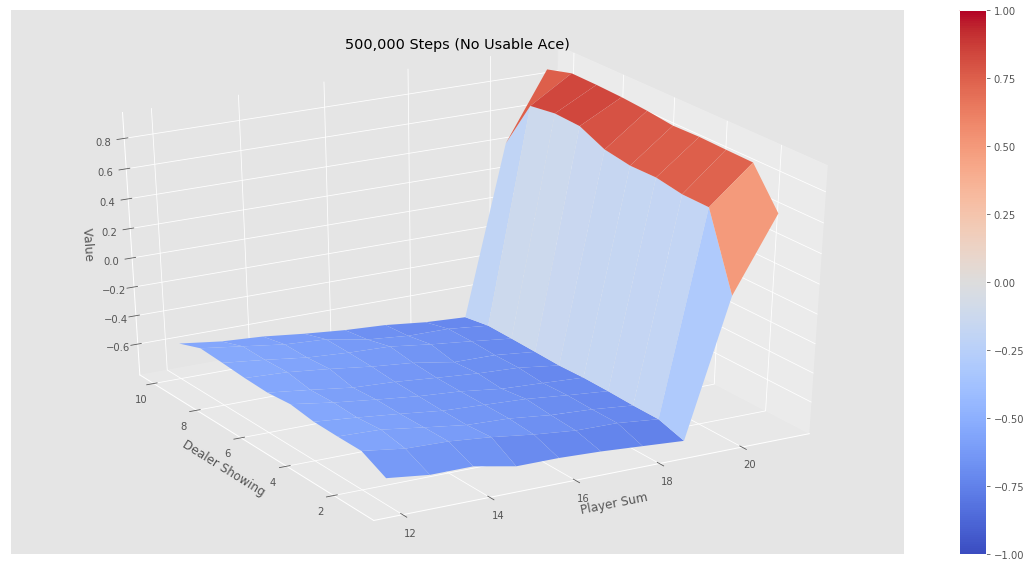

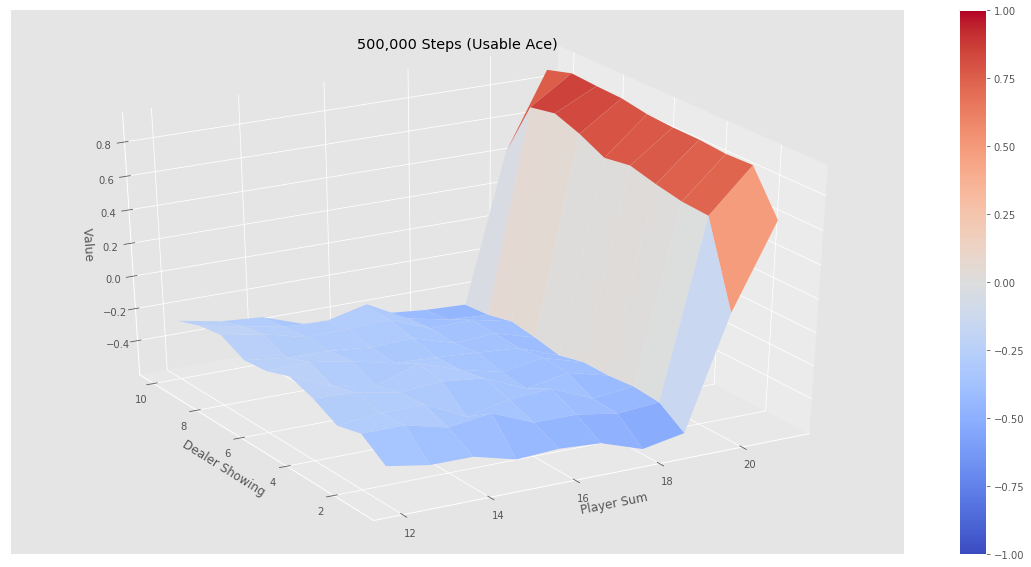

In [16]:
V_10k = mc_prediction(sample_policy, env, num_episodes=10000)
plotting.plot_value_function(V_10k, title="10,000 Steps")

V_500k = mc_prediction(sample_policy, env, num_episodes=500000)
plotting.plot_value_function(V_500k, title="500,000 Steps")

# Generalized policy iteration with Monte-Carlo evaluation

We know that Monte-Carlo is a policy evaluation way, we can choose greedy policy as the policy improvement.

BUT, greedy policy over value-state function requires the model of MDP, greedy policy over action-state function Q(s,a) is model-free 


## Monte-Carlo with Epsilon-Greedy policies
<img src="img/on-policy.png", style="max-width:70%; width: 70%">

In [17]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [18]:
env = BlackjackEnv()

In [34]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float)*epsilon/nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1 - epsilon)
        return A
        
    return policy_fn

In [37]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    for i_episode in range(1,num_episodes):
        
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
           
        # generate an episode
        episode = []
        state = env.reset()
        
        # run an episode by the default policy
        for t in range(100):
           # Take the action according to e-greedy probabiliy distribution 
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)),p=probs)
            # take the action will then generate next state(observation), current reward, done
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
 
        # find all action-value pair
        state_in_episode = set([(tuple(x[0]),x[1]) for x in episode])
        for state, action in state_in_episode:
            # find the first occurance of this state
            state_idx = next(i for i,x in enumerate(episode) if x[0] == state and x[1] == action)
            G = sum(x[2] * (discount_factor**i) for i,x in enumerate(episode[state_idx:]))
            returns_sum[(state, action)] += G
            returns_count[(state, action)] += 1.0
            Q[state][action] = returns_sum[(state, action)]/returns_count[(state,action)]

    
    return Q, policy

In [38]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 499000/500000.

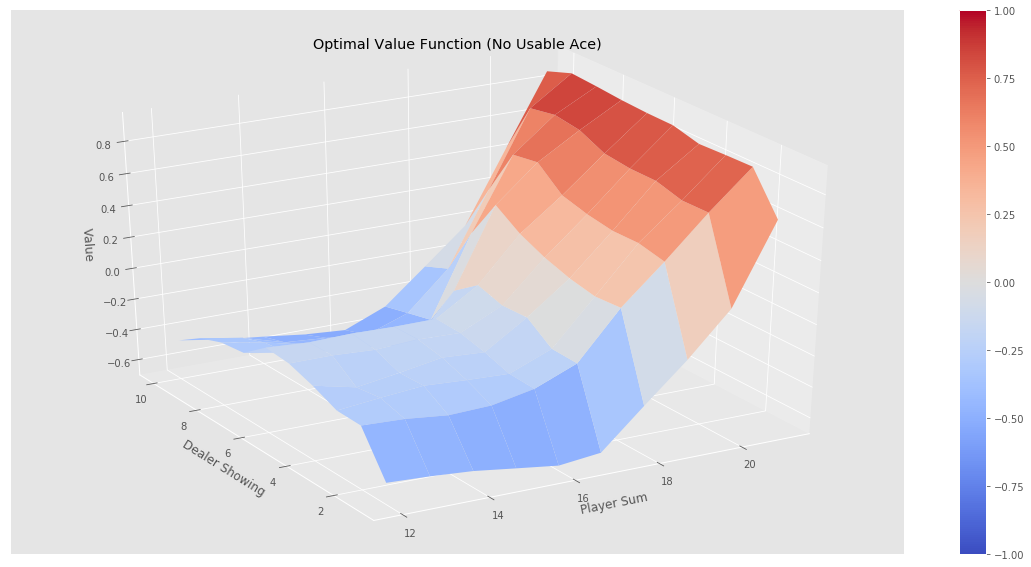

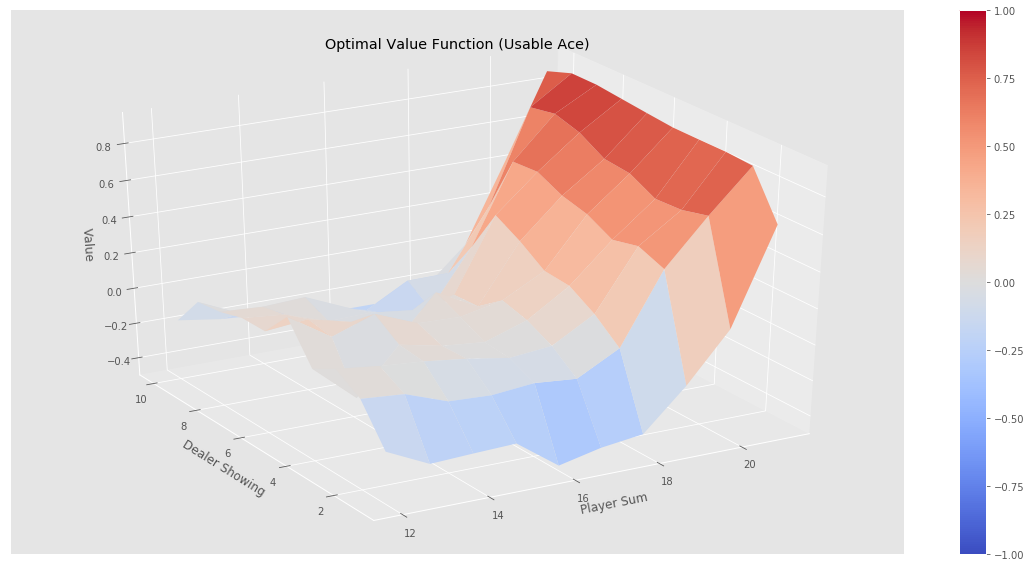

In [39]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
# Q is dictionary now, we can iterate Q via .items() function
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

In [25]:
env.action_space.n

2

In [31]:
np.random.choice(2,p=[0.9,0.1])

0

# Off-Policy MC Control with Weighted Importance Sampling

In [40]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict

from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [41]:
env = BlackjackEnv()

In [42]:

def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [43]:

def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        pass
        # Implement this!
    return policy_fn

In [44]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    # Implement this!
        
    return Q, target_policy

In [45]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)


In [ ]:

# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")